In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
from torchvision import transforms
import torchvision.utils
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
mnist = datasets.MNIST(root="./data", train=True, download=True, transform=transforms.ToTensor())

### Constructing the DataLoader

The PyTorch [DataLoader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) class is an efficient implementation of an iterator that can perform useful preprocessing and returns batches of elements. Here, we use its ability to batch and shuffle data, but DataLoaders are capable of much more.

Note that each time we iterate over a DataLoader, it starts again from the beginning.

Below we use `torchvision.utils.make_grid()` to show a sample batch of inputs.

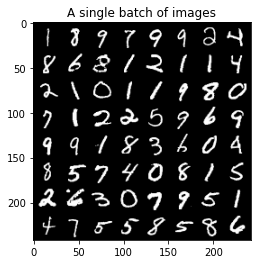

In [3]:
data_loader = torch.utils.data.DataLoader(mnist, batch_size=64, shuffle=True)

# Show one batch of images. Each batch of images has shape [batch_size, 1, 28, 28],
# where 1 is the "channels" dimension of the image.
for images,labels in data_loader:
    grid_img = torchvision.utils.make_grid(images)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.title("A single batch of images")
    break

### Defining the Network
Here we define a simple 1-hidden-layer neural network for classification on MNIST. It takes a parameter that determines the hidden size of the hidden layer.

In [4]:
class MNISTNetwork(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.linear_0 = nn.Linear(784, hidden_size)
        self.linear_1 = nn.Linear(hidden_size, 10)
        
    def forward(self, inputs):
        x = self.linear_0(inputs)
        x = torch.sigmoid(x)
        return self.linear_1(x)

### Instantiating the Networks

We will consider three networks.

1. One that only has a single hidden unit and all of its weights are initialized to exactly 0.
2. One that has 64 hidden units and all of its weights are initialized to exactly 0.
3. One that has 64 hidden units and the weights are initialized using Torch's default, [Kaiming Uniform initialization](https://pytorch.org/docs/stable/nn.init.html).

In the code below, we utilize some important PyTorch methods which you'll want to be familiar with. This includes:

* [`torch.nn.Module.parameters()`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html): Returns an iterator over module parameters (i.e. for passing to an optimizer that will update those parameters).

* [`torch.Tensor.view()`](https://pytorch.org/docs/stable/generated/torch.Tensor.view.html): Returns a *view* into the original Tensor. The result of this method shares the same underlying data as the input Tensor. This avoids copying the data, which means it can be mnore efficient, but it also means that when the original Tensor is modified, so is the view!

* [`torch.Tensor.item()`](https://pytorch.org/docs/stable/generated/torch.Tensor.item.html#torch.Tensor.item): Returns the value of a single-element Tensor as a standard Python number. This only works for tensors with one element. For other cases, see `torch.Tensor.tolist()`.

* [`torch.Tensor.backward()`](https://pytorch.org/docs/stable/generated/torch.Tensor.backward.html): Computes the gradients of current tensor wrt the graph leaves (note that this is only called if `Tensor.requires_grad` is True, which is the case by default). After calling this, a Tensor's `.grad` attribute is updated with the current gradients. These are used, for example, when calling `.step()` method of an optimizer.

* [`torch.optim.Optimizer.zero_grad()`](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.zero_grad.html): Sets the gradients of all variables to zero. This should be conducted before each step of an optimization procedure (i.e., for each batch of training a DNN). If `.zero_grad()` is not called, gradients accumulate (add) over iterations.

In [5]:
small_net = MNISTNetwork(1)
large_net = MNISTNetwork(64)
large_net_rand = MNISTNetwork(64)

In [6]:
for p in zip(small_net.parameters(), large_net.parameters()):
    p1, p2 = p
    p1.data = torch.zeros_like(p1.data)
    p2.data = torch.zeros_like(p2.data)

### Training

We will train all three networks simulateneously using the same learning rate. After each epoch, we print the current loss of each network.

In [7]:
epochs = 32

optimizer_small = optim.Adam(small_net.parameters(), lr=5e-3)
optimizer_large = optim.Adam(large_net.parameters(), lr=5e-3)
optimizer_large_rand = optim.Adam(large_net_rand.parameters(), lr=5e-3)

for i in range(epochs):
    loss_small_epoch = 0.
    loss_large_epoch = 0.
    loss_large_rand_epoch = 0.
    
    for batch in tqdm(data_loader):
        images, labels = batch
        images, labels = images, labels
        
        images = images.view(-1, 784)
        
        optimizer_small.zero_grad()
        optimizer_large.zero_grad()
        optimizer_large_rand.zero_grad()
        
        y_small = small_net(images)
        y_large = large_net(images)
        y_large_rand = large_net_rand(images)
        
        loss_small = F.cross_entropy(y_small, labels)
        loss_large = F.cross_entropy(y_large, labels)
        loss_large_rand = F.cross_entropy(y_large_rand, labels)
        
        loss_small_epoch += loss_small.item()
        loss_large_epoch += loss_large.item()
        loss_large_rand_epoch += loss_large_rand.item()
        
        loss_small.backward()
        loss_large.backward()
        loss_large_rand.backward()
        
        optimizer_small.step()
        optimizer_large.step()
        optimizer_large_rand.step()
        
    print("Small Loss:", loss_small_epoch / len(data_loader))
    print("Large Loss:", loss_large_epoch / len(data_loader))
    print("Large rand Loss:", loss_large_rand_epoch / len(data_loader))

  1%|▏         | 12/938 [00:00<00:08, 113.19it/s]

Small Loss: 1.9653773850469447
Large Loss: 1.7691148120457176
Large rand Loss: 0.32225943708232346


  1%|▏         | 12/938 [00:00<00:08, 114.64it/s]

Small Loss: 1.8007648818528474
Large Loss: 1.591421776361811
Large rand Loss: 0.14307911678163737


  1%|          | 11/938 [00:00<00:08, 106.89it/s]

Small Loss: 1.7754631050105796
Large Loss: 1.541870578646914
Large rand Loss: 0.10535131760144126


  1%|▏         | 12/938 [00:00<00:08, 111.93it/s]

Small Loss: 1.7660997954767141
Large Loss: 1.5250169689467212
Large rand Loss: 0.0832289993804671


  1%|          | 11/938 [00:00<00:09, 102.26it/s]

Small Loss: 1.7597641337400816
Large Loss: 1.520738815702101
Large rand Loss: 0.06850804357892716


  1%|▏         | 12/938 [00:00<00:08, 111.54it/s]

Small Loss: 1.7517259124753826
Large Loss: 1.5135384185481935
Large rand Loss: 0.058282612074813896


  1%|          | 11/938 [00:00<00:08, 108.88it/s]

Small Loss: 1.7411294252887717
Large Loss: 1.5108274831446504
Large rand Loss: 0.04964475166067473


  1%|▏         | 12/938 [00:00<00:08, 113.00it/s]

Small Loss: 1.7284150821313675
Large Loss: 1.50909600989905
Large rand Loss: 0.04239305789455342


  1%|          | 11/938 [00:00<00:08, 106.54it/s]

Small Loss: 1.7165488069499735
Large Loss: 1.5079237941994088
Large rand Loss: 0.03548161863217325


  1%|▏         | 12/938 [00:00<00:08, 114.00it/s]

Small Loss: 1.7081243620752526
Large Loss: 1.5079518726893835
Large rand Loss: 0.032258128287391795


  1%|          | 11/938 [00:00<00:08, 105.61it/s]

Small Loss: 1.6982567778020017
Large Loss: 1.5041666942110448
Large rand Loss: 0.026698528619325246


  1%|          | 9/938 [00:00<00:12, 77.21it/s]

Small Loss: 1.6914531681329203
Large Loss: 1.5070734082508697
Large rand Loss: 0.023921146165211696


  1%|▏         | 12/938 [00:00<00:07, 117.76it/s]

Small Loss: 1.684154798481256
Large Loss: 1.5022577077849333
Large rand Loss: 0.02372061598215447


  1%|▏         | 13/938 [00:00<00:07, 120.23it/s]

Small Loss: 1.6789440003031098
Large Loss: 1.5030099018804555
Large rand Loss: 0.020083684421048614


  1%|▏         | 12/938 [00:00<00:07, 119.08it/s]

Small Loss: 1.6754160913577212
Large Loss: 1.5024545715053452
Large rand Loss: 0.01902387527616641


  1%|          | 11/938 [00:00<00:09, 101.56it/s]

Small Loss: 1.6701044252178054
Large Loss: 1.5012980394526076
Large rand Loss: 0.015888710764719784


  1%|▏         | 12/938 [00:00<00:07, 119.44it/s]

Small Loss: 1.6673169402933832
Large Loss: 1.5030907546279273
Large rand Loss: 0.014259491353448398


  1%|▏         | 13/938 [00:00<00:07, 120.54it/s]

Small Loss: 1.6606399458862826
Large Loss: 1.501739643148776
Large rand Loss: 0.01473792636624179


  1%|          | 7/938 [00:00<00:15, 58.80it/s]

Small Loss: 1.6542420225865297
Large Loss: 1.503003201123748
Large rand Loss: 0.012198911213631512


  1%|          | 11/938 [00:00<00:08, 105.59it/s]

Small Loss: 1.6473971431189254
Large Loss: 1.5033805226720471
Large rand Loss: 0.014074451071668171


  1%|▏         | 12/938 [00:00<00:07, 119.31it/s]

Small Loss: 1.640233465349242
Large Loss: 1.5026245990287521
Large rand Loss: 0.012415689048173315


  1%|▏         | 12/938 [00:00<00:07, 117.44it/s]

Small Loss: 1.6366289218605707
Large Loss: 1.5019202104001157
Large rand Loss: 0.008756707007697942


  1%|▏         | 12/938 [00:00<00:07, 119.70it/s]

Small Loss: 1.6302211870516796
Large Loss: 1.503016941964245
Large rand Loss: 0.008281775715228517


  1%|▏         | 12/938 [00:00<00:07, 119.60it/s]

Small Loss: 1.6247983736270017
Large Loss: 1.499519855610089
Large rand Loss: 0.012281459499008284


  1%|▏         | 13/938 [00:00<00:07, 121.00it/s]

Small Loss: 1.6167287140258595
Large Loss: 1.504597606562348
Large rand Loss: 0.008737740114552224


  1%|▏         | 13/938 [00:00<00:07, 119.32it/s]

Small Loss: 1.6161306109001388
Large Loss: 1.5028151793520588
Large rand Loss: 0.011179485601514936


  1%|▏         | 12/938 [00:00<00:08, 109.22it/s]

Small Loss: 1.609934631695371
Large Loss: 1.5002928712983121
Large rand Loss: 0.00824372626419466


  1%|▏         | 12/938 [00:00<00:07, 119.73it/s]

Small Loss: 1.6070402381516724
Large Loss: 1.4993105465923544
Large rand Loss: 0.008217276727408927


  1%|▏         | 12/938 [00:00<00:07, 118.17it/s]

Small Loss: 1.6055648727203482
Large Loss: 1.506420293977774
Large rand Loss: 0.010378440634260404


  1%|          | 11/938 [00:00<00:08, 104.30it/s]

Small Loss: 1.6037178017945686
Large Loss: 1.501652993881372
Large rand Loss: 0.007176022771486685


  1%|▏         | 12/938 [00:00<00:08, 114.30it/s]

Small Loss: 1.6024280204447603
Large Loss: 1.4988863943482258
Large rand Loss: 0.006112509311864034


100%|██████████| 938/938 [00:08<00:00, 116.34it/s]

Small Loss: 1.600621154821758
Large Loss: 1.4989804560695883
Large rand Loss: 0.006024113362972455


In [8]:
W_0 = large_net.linear_0.weight
b_0 = large_net.linear_0.bias

W_1 = large_net.linear_1.weight
b_1 = large_net.linear_1.bias

In [9]:
print("W_0 => All weights equal for each hidden unit:", (W_0[0, :].unsqueeze(0) == W_0).all().item())
print("Example of weights:")
print(W_0[:, 256])

W_0 => All weights equal for each hidden unit: True
Example of weights:
tensor([-0.0529, -0.0529, -0.0529, -0.0529, -0.0529, -0.0529, -0.0529, -0.0529,
        -0.0529, -0.0529, -0.0529, -0.0529, -0.0529, -0.0529, -0.0529, -0.0529,
        -0.0529, -0.0529, -0.0529, -0.0529, -0.0529, -0.0529, -0.0529, -0.0529,
        -0.0529, -0.0529, -0.0529, -0.0529, -0.0529, -0.0529, -0.0529, -0.0529,
        -0.0529, -0.0529, -0.0529, -0.0529, -0.0529, -0.0529, -0.0529, -0.0529,
        -0.0529, -0.0529, -0.0529, -0.0529, -0.0529, -0.0529, -0.0529, -0.0529,
        -0.0529, -0.0529, -0.0529, -0.0529, -0.0529, -0.0529, -0.0529, -0.0529,
        -0.0529, -0.0529, -0.0529, -0.0529, -0.0529, -0.0529, -0.0529, -0.0529],
       grad_fn=<SelectBackward>)


In [10]:
print("W_1 => All weights equal for each hidden unit:", (W_1[:, 0].unsqueeze(-1) == W_1).all().item())
print("Weights:")
print(W_1[8])

W_1 => All weights equal for each hidden unit: True
Weights:
tensor([-0.3697, -0.3697, -0.3697, -0.3697, -0.3697, -0.3697, -0.3697, -0.3697,
        -0.3697, -0.3697, -0.3697, -0.3697, -0.3697, -0.3697, -0.3697, -0.3697,
        -0.3697, -0.3697, -0.3697, -0.3697, -0.3697, -0.3697, -0.3697, -0.3697,
        -0.3697, -0.3697, -0.3697, -0.3697, -0.3697, -0.3697, -0.3697, -0.3697,
        -0.3697, -0.3697, -0.3697, -0.3697, -0.3697, -0.3697, -0.3697, -0.3697,
        -0.3697, -0.3697, -0.3697, -0.3697, -0.3697, -0.3697, -0.3697, -0.3697,
        -0.3697, -0.3697, -0.3697, -0.3697, -0.3697, -0.3697, -0.3697, -0.3697,
        -0.3697, -0.3697, -0.3697, -0.3697, -0.3697, -0.3697, -0.3697, -0.3697],
       grad_fn=<SelectBackward>)


In [11]:
print("b_0 => All biases equal for each hidden unit:", (b_0[0] == b_0).all().item())
print("Bias:")
print(b_0)

b_0 => All biases equal for each hidden unit: True
Bias:
Parameter containing:
tensor([-1.5563, -1.5563, -1.5563, -1.5563, -1.5563, -1.5563, -1.5563, -1.5563,
        -1.5563, -1.5563, -1.5563, -1.5563, -1.5563, -1.5563, -1.5563, -1.5563,
        -1.5563, -1.5563, -1.5563, -1.5563, -1.5563, -1.5563, -1.5563, -1.5563,
        -1.5563, -1.5563, -1.5563, -1.5563, -1.5563, -1.5563, -1.5563, -1.5563,
        -1.5563, -1.5563, -1.5563, -1.5563, -1.5563, -1.5563, -1.5563, -1.5563,
        -1.5563, -1.5563, -1.5563, -1.5563, -1.5563, -1.5563, -1.5563, -1.5563,
        -1.5563, -1.5563, -1.5563, -1.5563, -1.5563, -1.5563, -1.5563, -1.5563,
        -1.5563, -1.5563, -1.5563, -1.5563, -1.5563, -1.5563, -1.5563, -1.5563],
       requires_grad=True)


In [12]:
print("b_1 => All biases equal for each hidden unit:", (b_1[0] == b_1).all().item())
print("Bias:")
print(b_1)

b_1 => All biases equal for each hidden unit: False
Bias:
Parameter containing:
tensor([ 3.7292, -0.0961,  3.4068,  2.0403, -2.9260,  2.3082,  4.5227, -7.2908,
         1.9778, -5.0011], requires_grad=True)


## Tensor and Layer sizes

Below is an implementation of the network from the section handout. We use `torchinfo-summary()` to view the size of the data as it flows through the network; additionally, we print and the size of the weights and biases of the layers during a forward pass. Note that this network is just for demonstration and may not work well in practice.

*Note:* this section uses the [`torchinfo`](https://github.com/TylerYep/torchinfo) package; see the github repo for installation instructions or run one of the following lines below:

*install via conda*:
```
conda install -c conda-forge torchinfo
```

*install via pip*:
```
pip install torchinfo
```

In [13]:
from torchinfo import summary

class DemoNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 16, 3, 1, 1)
        self.max1 = nn.MaxPool2d(2, 2, 0)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 0)
        self.max2 = nn.MaxPool2d(2, 2, 1)
        self.conv3 = nn.Conv2d(32, 8, 1, 1, 0)
        self.conv4 = nn.Conv2d(8, 4, 5, 1, 0)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(576, 10)
    
    @property
    def trainable_layers(self):
        """A utility property to easily access a list of all model layers."""
        return [self.conv1, self.conv2, self.conv3, self.conv4, self.linear1]
        
    def forward(self, inputs):
        """Implements the forward pass."""
        x = self.conv1(inputs)
        x = self.max1(x)
        x = self.conv2(x)
        x = self.max2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.flatten(x)
        x = self.linear1(x)
        return x

    def print_weight_shapes(self):
        """Utility function to print the shapes of weights in trainable layers."""
        for layer in self.trainable_layers:
            print(f"Weight shape: {layer.weight.shape}; Bias shape: {layer.bias.shape}")

demo = DemoNetwork()
batch_size = 64
summary(demo, input_size=(batch_size, 3, 64, 64))


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [64, 16, 64, 64]          448
├─MaxPool2d: 1-2                         [64, 16, 32, 32]          --
├─Conv2d: 1-3                            [64, 32, 30, 30]          4,640
├─MaxPool2d: 1-4                         [64, 32, 16, 16]          --
├─Conv2d: 1-5                            [64, 8, 16, 16]           264
├─Conv2d: 1-6                            [64, 4, 12, 12]           804
├─Flatten: 1-7                           [64, 576]                 --
├─Linear: 1-8                            [64, 10]                  5,770
Total params: 11,926
Trainable params: 11,926
Non-trainable params: 0
Total mult-adds (M): 6.10
Input size (MB): 3.15
Forward/backward pass size (MB): 49.65
Params size (MB): 0.05
Estimated Total Size (MB): 52.84

In [14]:
demo.print_weight_shapes()

Weight shape: torch.Size([16, 3, 3, 3]); Bias shape: torch.Size([16])
Weight shape: torch.Size([32, 16, 3, 3]); Bias shape: torch.Size([32])
Weight shape: torch.Size([8, 32, 1, 1]); Bias shape: torch.Size([8])
Weight shape: torch.Size([4, 8, 5, 5]); Bias shape: torch.Size([4])
Weight shape: torch.Size([10, 576]); Bias shape: torch.Size([10])
